# Test and Trial on Gaussian Mixture Distribution.

In [1]:
%matplotlib inline

import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.distributions import (
    Categorical, NormalWithSoftplusScale, Mixture)

from nn4post import InferenceBuilder
try:
    from tensorflow.contrib.distributions import Independent
except:
    from nn4post.utils.independent import Independent

/Users/shuiruge/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# For reproducibility
SEED = 123456
tf.set_random_seed(SEED)
np.random.seed(SEED)

## Functions

In [3]:
def make_log_posterior(target_c, target_mu, target_zeta):
  
    target_c = tf.convert_to_tensor(target_c)
    target_mu = tf.convert_to_tensor(target_mu)
    target_zeta = tf.convert_to_tensor(target_zeta)

    # -- Gaussian Mixture Distribution
    with tf.name_scope('posterior'):

      cat = Categorical(probs=target_c)
      components = [
          Independent(
              NormalWithSoftplusScale(target_mu[i], target_zeta[i])
          ) for i in range(target_c.shape[0])
      ]
      p = Mixture(cat, components)

      def log_posterior(theta):
          return p.log_prob(theta)

    return log_posterior

In [4]:
def shall_stop(loss_values, tolerance, n_means=20):
    """Returns `True` if the relative variance of loss-value in
    `loss_values` becomes smaller than `tolerance`, else `False`.
    The loss-value is smeared by its nearby `n_means` loss-values.
    """
    if len(loss_values) < 2 * n_means:
        return False

    else:
        previous_loss = np.mean(loss_values[-2*n_means:-n_means])
        current_loss = np.mean(loss_values[-n_means:])
        delta_loss = previous_loss - current_loss
        relative_delta_loss = abs( delta_loss / (current_loss + 1e-8) )

        if relative_delta_loss < tolerance:
            return True
        else:
            return False


def test(target_c, target_mu, target_zeta, init_var,
         tolerance=1e-2, n_iters=None, optimizer=None,
         **inference_kwargs):
    """Test on Gaussian mixture distribution as the target.
    
    Args:
        target_c: Numpy array.
        target_mu: Numpy array.
        target_zeta: Numpy array.
        init_var: Dictionary with keys: "a", "mu", and "zeta" and
            values numpy arraies.
        XXX
            `n_iters` is more preferable than `tolerance`.
        inference_kwargs: Dictionary, as the kwargs (parameters)
            of `InferenceBuilder.__init__()`.
    
    Returns:
        Dictionary with keys: "loss", "a", "mu", and "zeta", and
        values the values at each iteration, collected in a list.
    """

    tf.reset_default_graph()

    log_p = make_log_posterior(target_c, target_mu, target_zeta)

    n_c, n_d = init_var['mu'].shape
    ib = InferenceBuilder(n_c, n_d, log_p, **inference_kwargs)
    
    a = tf.Variable(init_var['a'], dtype='float32')
    mu = tf.Variable(init_var['mu'], dtype='float32')
    zeta = tf.Variable(init_var['zeta'], dtype='float32')
    loss, gradients = ib.make_loss_and_gradients(a, mu, zeta)
    
    if optimizer is None:
        optimizer = tf.train.RMSPropOptimizer(0.05)
        #optimizer = tf.train.AdamOptimizer(0.005)
    train_op = optimizer.apply_gradients(gradients)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)

        test_result = {'loss': [], 'a': [], 'mu': [], 'zeta': []}
        step = 0
            
        def iter_body():
            
            nonlocal step

            _, loss_val, a_val, mu_val, zeta_val \
                = sess.run([train_op, loss, a, mu, zeta])

            test_result['loss'].append(loss_val)
            test_result['a'].append(a_val)
            test_result['mu'].append(mu_val)
            test_result['zeta'].append(zeta_val)
            
            step += 1
            if (step+1) % 100 == 0:
                print(step, loss_val)

        if n_iters:
            for i in range(n_iters):
                iter_body()
                
        else:
            while not shall_stop(test_result['loss'], tolerance):
                iter_body()
                
    return test_result

In [5]:
# Helpers

def softplus(x, limit=10.):
    return np.where(x<limit, np.log(1. + np.exp(x)), x)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def plot_trajectory(trajectory, i=0, j=1):
    """Plot the 2D projection of the trajectory `trajectory`.
    
    Args:
        trajectory: List of 2D numpy array.
        i: Integer, as the x-axis to be plotted, optional.
        j: Integer, as the y-axis to be plotted, optional.
    """
    n_points = len(trajectory)
    x = [_[i] for _ in trajectory]
    y = [_[j] for _ in trajectory]
    delta_x = [x[i+1] - x[i] for i in range(n_points-1)]
    delta_y = [y[i+1] - y[i] for i in range(n_points-1)]
    plt.quiver(x, y, delta_x, delta_y)

In [6]:
def display(test_result):
    """For visualization."""
    
    print('Final loss:', np.mean(test_result['loss'][-20:]))
    
    for i in range(n_c):

        trajectory = [_[i,:] for _ in test_result['mu']]
        plot_trajectory(trajectory)
        plt.show()

        c = [softmax(_) for _ in test_result['a']]
        plt.plot([_[i] for _ in c])
        plt.show()

        print('--------------')

## Experiments

### The Effect of $\beta$

#### Configuration

In [28]:
n_d = 1000
ones = np.ones([n_d]).astype('float32')
target_c = np.array([0.7, 0.25, 0.05]).astype('float32')
target_mu = np.array([-2*ones, 0*ones, 2*ones]).astype('float32')
target_zeta = np.array([ones, ones, ones]).astype('float32')

n_c = 10
init_var = {
    'a': np.zeros([n_c]).astype('float32'),
    'mu': np.random.normal(0., 30., size=[n_c, n_d]).astype('float32'),
    'zeta': np.zeros([n_c, n_d]).astype('float32'),
}

init_var['mu'][0] = -2 * np.ones([n_d]).astype('float32')

tolerance = 1e-3
n_iters = 2000

#### Experiment

* When $\beta = 0$

In [16]:
%%time

test_result_0 = test(target_c, target_mu, target_zeta,init_var,
                     tolerance=tolerance, n_iters=n_iters, beta=0.0)

99 1265.1896
199 120.56723
299 91.90917
399 69.67917
499 52.085434
599 37.83327
699 26.693905
799 18.820646
899 13.792197
999 9.87311
1099 7.0486827
1199 5.578548
1299 4.45383
1399 3.5842123
1499 3.2381592
1599 2.571051
1699 2.4567008
1799 2.3262167
1899 2.1289198
1999 1.9581183
CPU times: user 2h 26min 59s, sys: 18min 55s, total: 2h 45min 54s
Wall time: 1d 9h 22min 1s


* When $\beta = 1$:

In [17]:
%%time

# The same configuration as `test_result_0`, but with `beta=1.0`
test_result_1 = test(target_c, target_mu, target_zeta,init_var,
                     tolerance=tolerance, n_iters=n_iters, beta=1.0)

99 483.03787
199 93.27321
299 68.1297
399 49.337177
499 37.72237
599 26.407013
699 19.156126
799 13.564911
899 9.651664
999 7.832226
1099 5.7055926
1199 4.3387313
1299 3.8160827
1399 3.2923517
1499 2.3840477
1599 3.0871496
1699 2.4555993
1799 2.117228
1899 2.1093657
1999 1.67155
CPU times: user 2h 26min 38s, sys: 20min 9s, total: 2h 46min 47s
Wall time: 56min 4s


#### Visualization

Final loss: 2.0204206


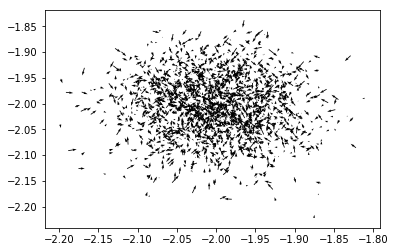

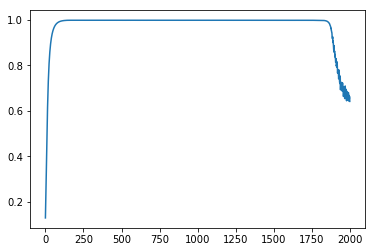

--------------


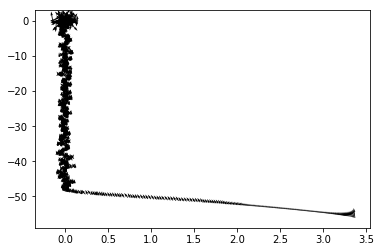

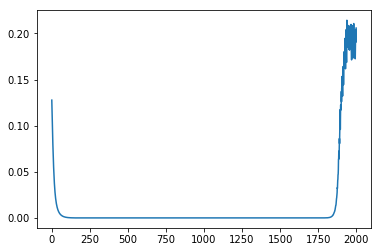

--------------


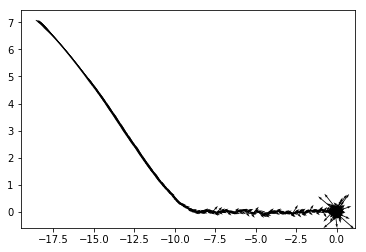

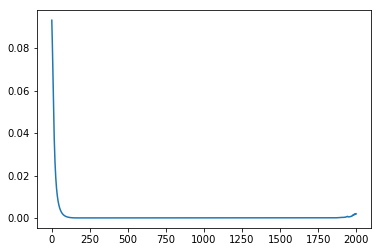

--------------


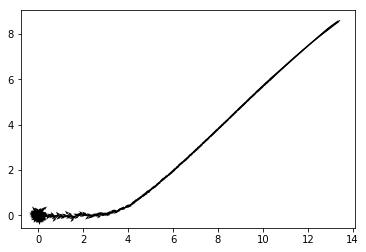

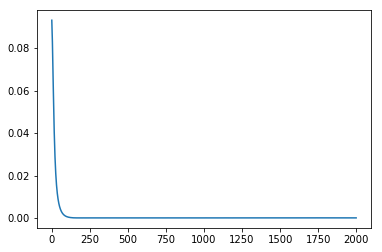

--------------


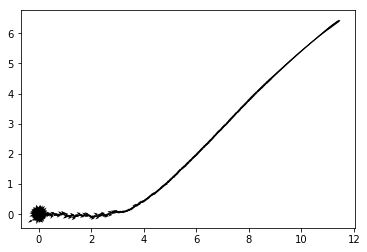

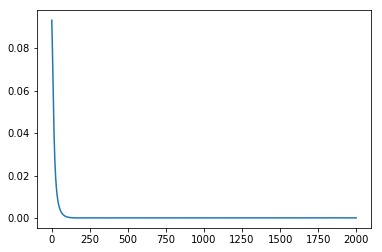

--------------


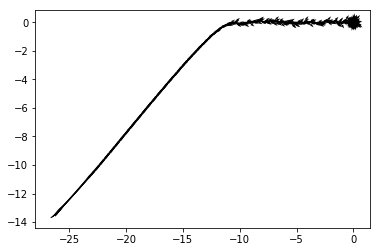

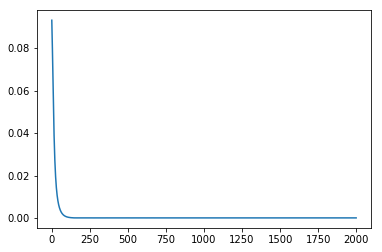

--------------


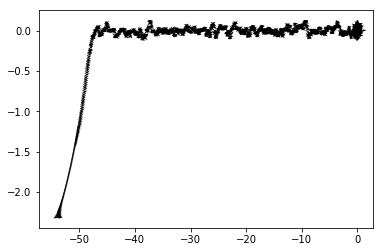

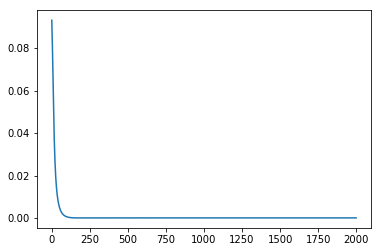

--------------


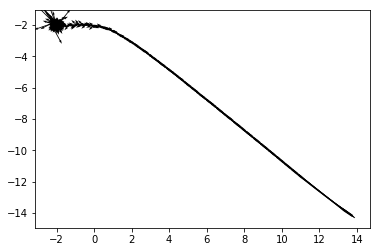

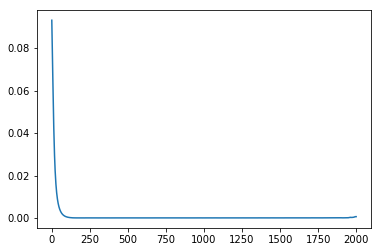

--------------


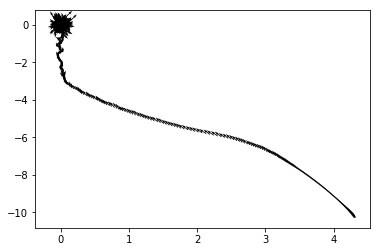

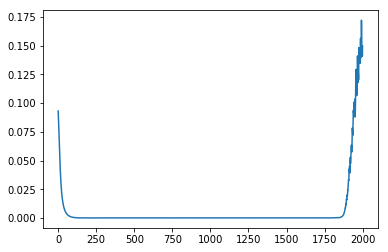

--------------


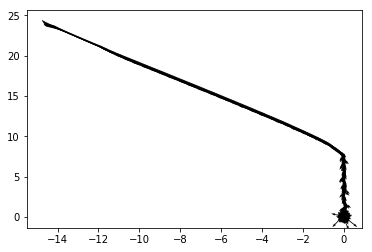

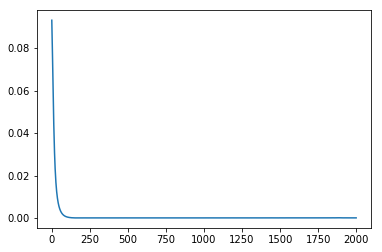

--------------


In [19]:
display(test_result_0)

Final loss: 1.7673404


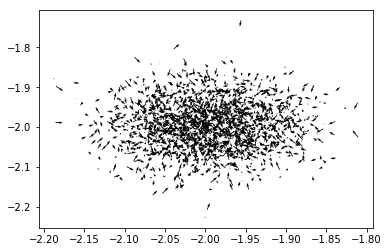

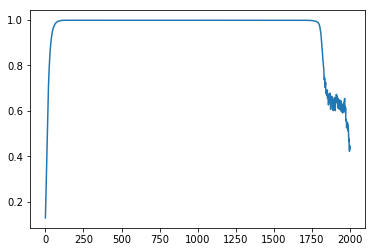

--------------


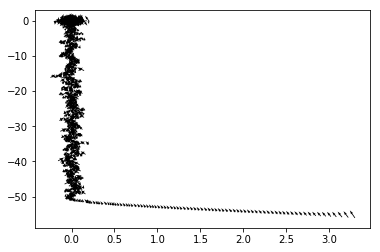

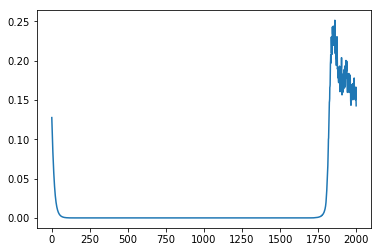

--------------


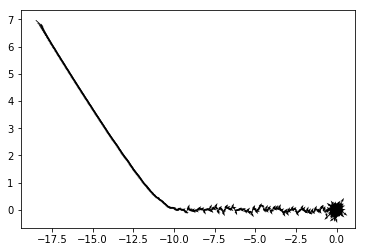

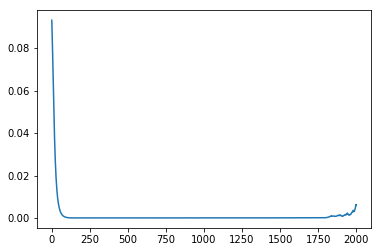

--------------


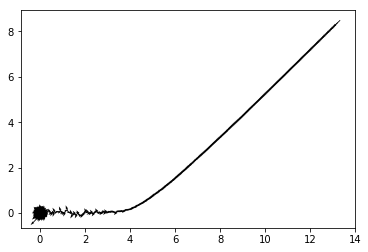

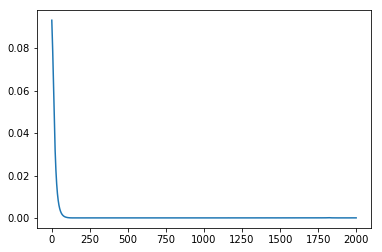

--------------


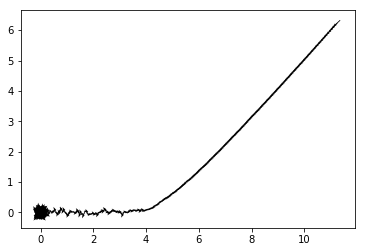

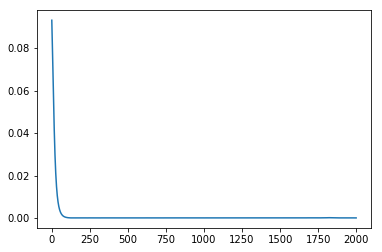

--------------


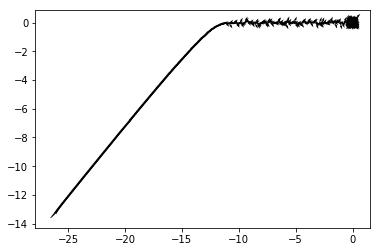

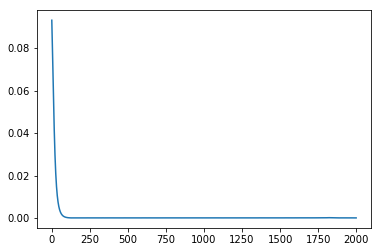

--------------


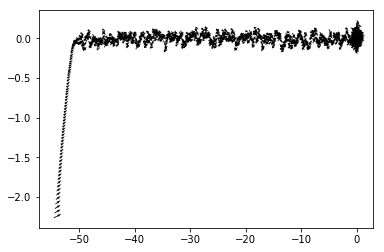

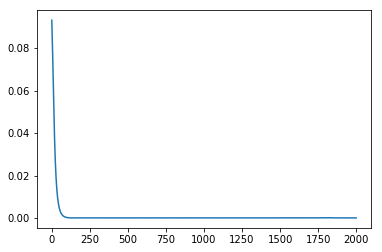

--------------


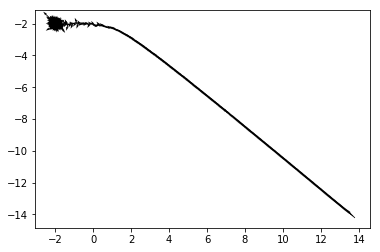

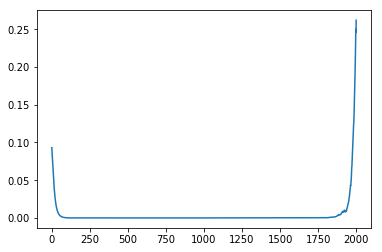

--------------


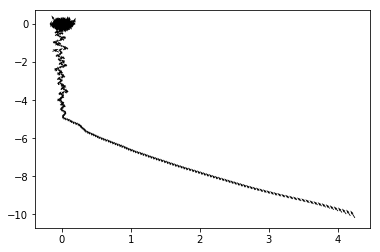

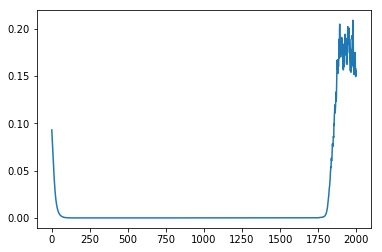

--------------


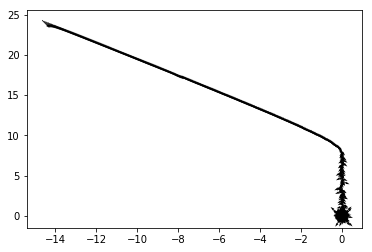

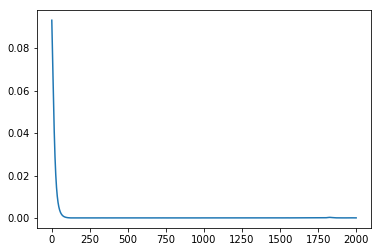

--------------


In [20]:
display(test_result_1)

In [ ]:
x = [i for i in range(100, 300)]
plt.plot(x, [test_result_0['loss'][i] for i in x], color='green')
plt.plot(x, [test_result_1['loss'][i] for i in x], color='red')
plt.show()

#### Conclusion

* The loss of $\beta = 1$ converges manifestly faster than that of $\beta = 0$.
* The final effect of $\beta = 1$ looks better than $\beta = 0$. But the improvement is little.

### Bad Initial Value

#### Configuration

In [7]:
n_d = 2
ones = np.ones([n_d]).astype('float32')
target_c = np.array([0.8, 0.2]).astype('float32')
target_mu = np.array([-2*ones, 2*ones]).astype('float32')
target_zeta = np.array([ones, ones, ones]).astype('float32')

n_c = 2
init_var = {
    'a': np.zeros([n_c]).astype('float32'),
    'mu': np.random.normal(0., 5., size=[n_c, n_d]).astype('float32'),
    'zeta': np.zeros([n_c, n_d]).astype('float32'),
}

init_var['a'][0] = 4.5
init_var['a'][1] = -4.5
init_var['mu'][0] = -2 * np.ones([n_d]).astype('float32')
init_var['mu'][1] = 2 * np.ones([n_d]).astype('float32')

tolerance = 1e-3
n_iters = 1000

#### Experiment

In [8]:
%%time

test_result = test(
    target_c, target_mu, target_zeta,init_var,
    tolerance=tolerance, n_iters=n_iters,
    optimizer=tf.train.GradientDescentOptimizer(0.05))

99 0.01131916
199 0.0003809929
299 0.00039052963
399 0.0015251637
499 0.0019977093
599 0.0020577908
699 0.0025014877
799 -0.00084352493
899 -0.0034310818
999 -0.0005404949
CPU times: user 5min 47s, sys: 42.7 s, total: 6min 30s
Wall time: 2min 10s


In addition, as comparison:

In [13]:
%%time

test_result_0 = test(
    target_c, target_mu, target_zeta,init_var,
    tolerance=tolerance, n_iters=n_iters,
    optimizer=tf.train.GradientDescentOptimizer(0.05),
    beta=0.0)

99 0.21555813
199 0.19301483
299 0.21688125
399 0.20589831
499 0.20497245
599 0.19379029
699 0.21165763
799 0.19590095
899 0.1488343
999 0.2138204
CPU times: user 5min 44s, sys: 44.6 s, total: 6min 29s
Wall time: 2min 22s


#### Visualization

Final loss: 0.00022753477


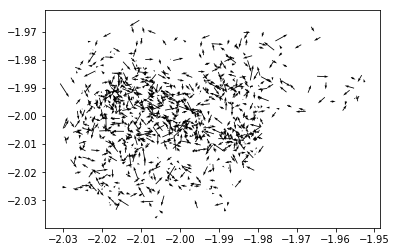

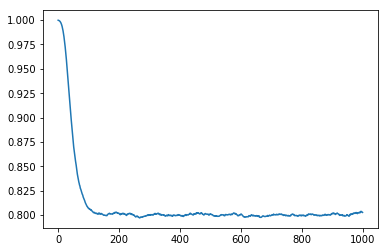

--------------


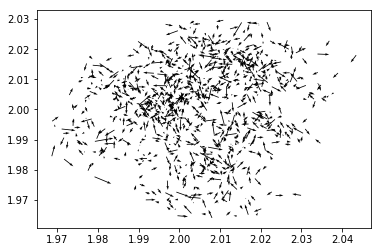

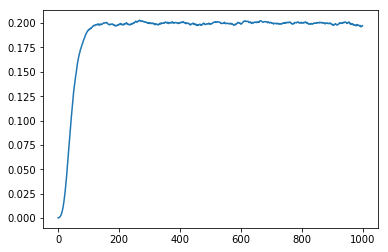

--------------


In [10]:
display(test_result)

Final loss: 0.19266991


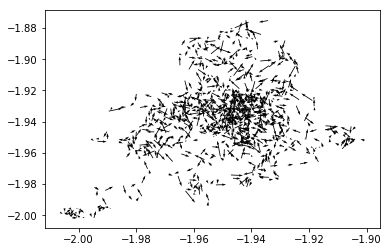

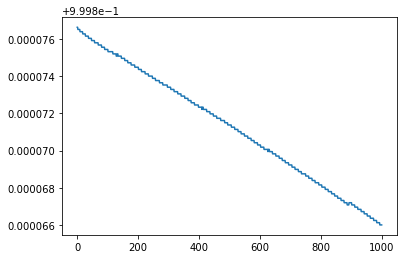

--------------


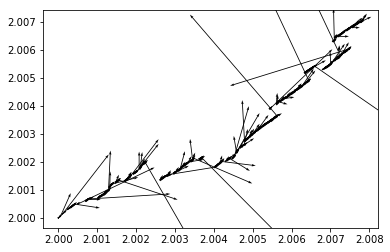

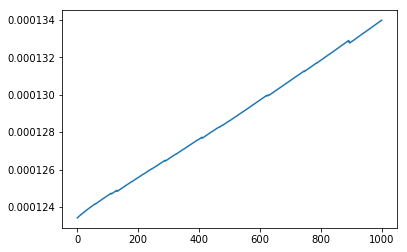

--------------


In [11]:
display(test_result_0)

Employ `tf.train.RMSPropOptimizer` instead:

In [14]:
%%time

test_result_1_rmsprop = test(
    target_c, target_mu, target_zeta,init_var,
    tolerance=tolerance, n_iters=n_iters,
    optimizer=tf.train.RMSPropOptimizer(0.05))

99 0.053870678
199 0.0061905384
299 -0.009759188
399 0.0078020096
499 -0.0021796227
599 -0.0020365715
699 -0.00525856
799 0.0032691956
899 -0.0010912418
999 0.001755476
CPU times: user 5min 55s, sys: 48.6 s, total: 6min 43s
Wall time: 2min 25s


In [16]:
%%time

test_result_0_rmsprop = test(
    target_c, target_mu, target_zeta,init_var,
    tolerance=tolerance, n_iters=n_iters,
    optimizer=tf.train.RMSPropOptimizer(0.05),
    beta=0.0)

99 0.18137637
199 0.0038778782
299 -0.00045108795
399 0.008279085
499 0.00016188622
599 0.0013623238
699 0.017677307
799 -0.0044214725
899 0.00048661232
999 -0.0013036728
CPU times: user 5min 51s, sys: 40.4 s, total: 6min 31s
Wall time: 2min 18s


Final loss: 0.005655539


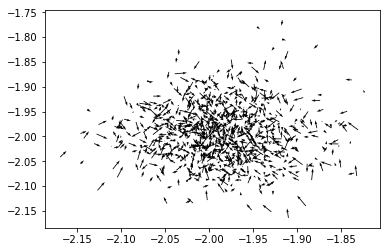

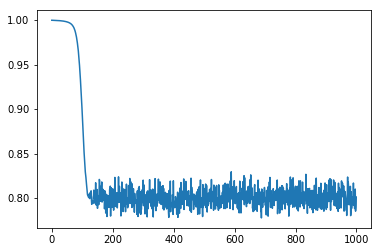

--------------


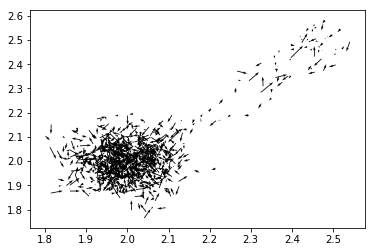

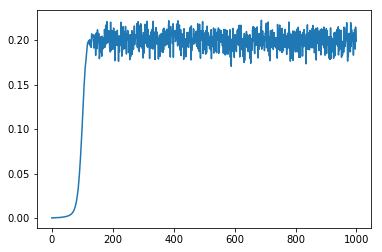

--------------


In [15]:
display(test_result_1_rmsprop)

Final loss: 0.00474869


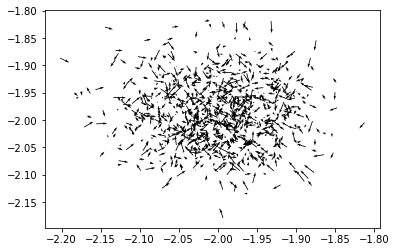

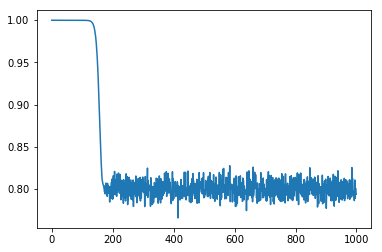

--------------


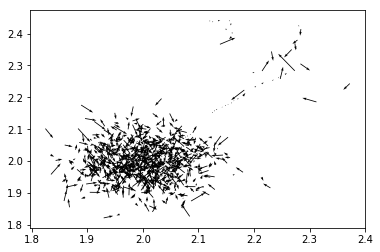

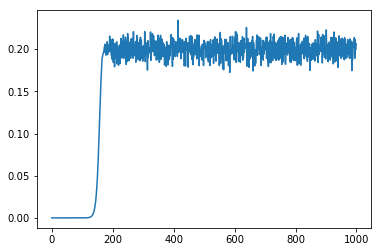

--------------


In [17]:
display(test_result_0_rmsprop)

### Bad Initial Value (Continued)

#### Configuration

In [18]:
n_d = 2
ones = np.ones([n_d]).astype('float32')
target_c = np.array([0.8, 0.2]).astype('float32')
target_mu = np.array([-2*ones, 2*ones]).astype('float32')
target_zeta = np.array([ones, ones, ones]).astype('float32')

n_c = 2
init_var = {
    'a': np.zeros([n_c]).astype('float32'),
    'mu': np.random.normal(0., 5., size=[n_c, n_d]).astype('float32'),
    'zeta': np.zeros([n_c, n_d]).astype('float32'),
}

init_var['a'][0] = -4.5
init_var['a'][1] = 4.5
init_var['mu'][0] = -2 * np.ones([n_d]).astype('float32')
init_var['mu'][1] = 2 * np.ones([n_d]).astype('float32')

tolerance = 1e-3
n_iters = 1000

#### Experiment

In [19]:
%%time

test_result = test(
    target_c, target_mu, target_zeta,init_var,
    tolerance=tolerance, n_iters=n_iters,
    optimizer=tf.train.GradientDescentOptimizer(0.05),
    beta=1.0)

99 0.009592295
199 -0.0023376942
299 0.0019052029
399 -0.0021891594
499 -0.0019745827
599 -0.0017058849
699 -3.528595e-05
799 0.0022397041
899 0.00027656555
999 0.0009498596
CPU times: user 6min 26s, sys: 44.9 s, total: 7min 11s
Wall time: 3h 2min 4s


In [20]:
%%time

test_result_0 = test(
    target_c, target_mu, target_zeta,init_var,
    tolerance=tolerance, n_iters=n_iters,
    optimizer=tf.train.GradientDescentOptimizer(0.05),
    beta=0.0)

99 1.4260157
199 1.2233877
299 1.1599414
399 1.0063695
499 0.64280003
599 0.30280688
699 0.18926254
799 0.19453457
899 0.17694426
999 0.21299691
CPU times: user 7min 7s, sys: 42.8 s, total: 7min 49s
Wall time: 7h 57min 52s


Or employing `tf.train.RMSPropOptimizer` instead (with the same learning-rate):

In [21]:
%%time

test_result_rmsprop = test(
    target_c, target_mu, target_zeta,init_var,
    tolerance=tolerance, n_iters=n_iters,
    optimizer=tf.train.RMSPropOptimizer(0.05),
    beta=1.0)

99 0.50422907
199 0.15061235
299 -0.0061035156
399 0.0023765564
499 0.008189678
599 -0.0011017323
699 -0.002503395
799 0.004994869
899 0.0024564266
999 0.0108428
CPU times: user 5min 52s, sys: 36.4 s, total: 6min 28s
Wall time: 2min 3s


In [22]:
%%time

test_result_0_rmsprop = test(
    target_c, target_mu, target_zeta,init_var,
    tolerance=tolerance, n_iters=n_iters,
    optimizer=tf.train.RMSPropOptimizer(0.05),
    beta=0.0)

99 0.81069463
199 0.20100856
299 0.19222045
399 0.18610787
499 0.17874932
599 0.15660286
699 0.007865429
799 -0.0014181137
899 -0.00033187866
999 -0.006998062
CPU times: user 5min 47s, sys: 34.6 s, total: 6min 21s
Wall time: 2min 3s


#### Visualization

Final loss: 0.00083161594


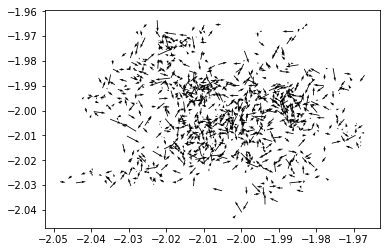

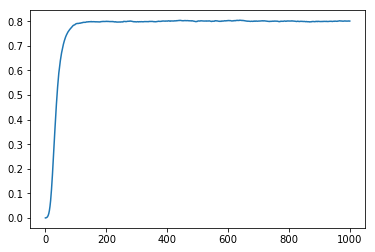

--------------


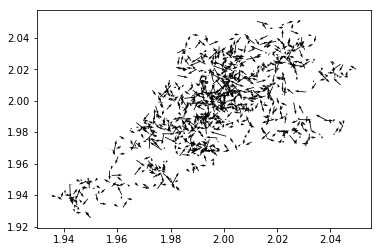

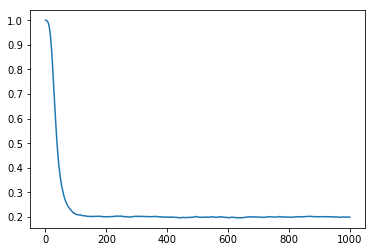

--------------


In [23]:
display(test_result)

Final loss: 0.19618735


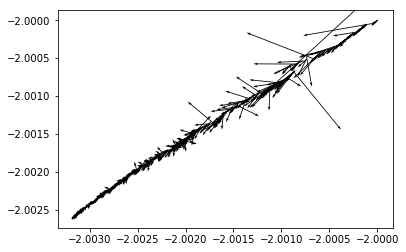

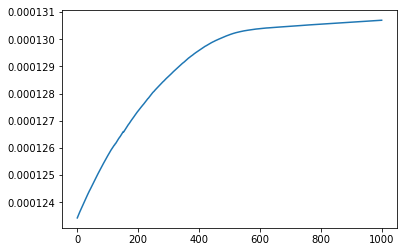

--------------


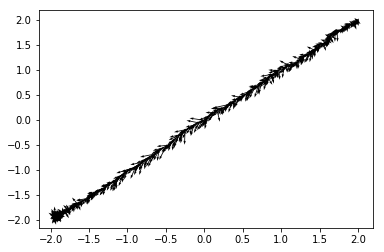

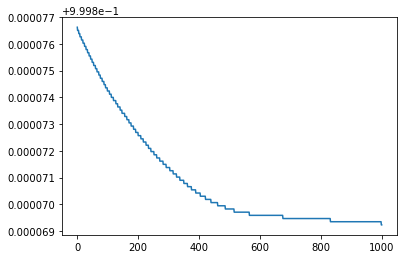

--------------


In [24]:
display(test_result_0)

Final loss: 0.005452895


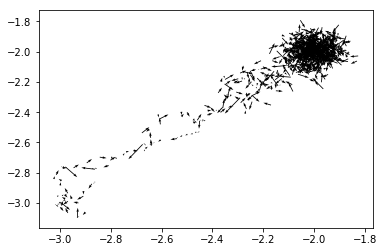

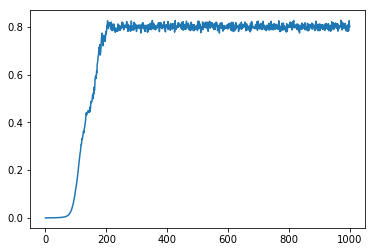

--------------


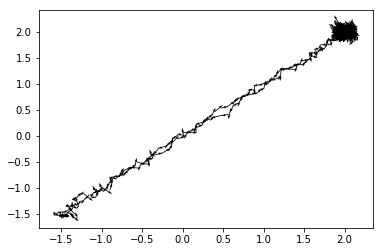

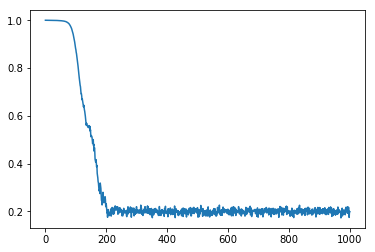

--------------


In [25]:
display(test_result_rmsprop)

Final loss: 0.0041019917


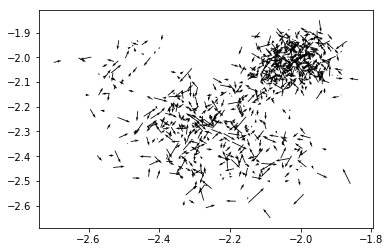

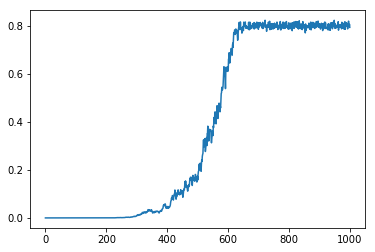

--------------


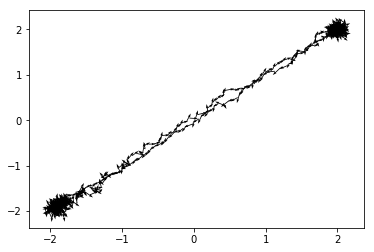

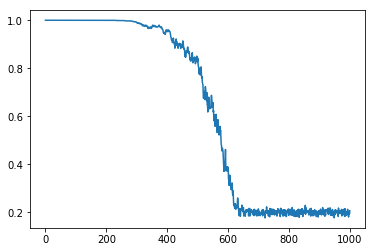

--------------


In [26]:
display(test_result_0_rmsprop)

#### Conclusion

* Herein we employ `tf.train.GradientDescentOptimizer` specifically.
* Starting at bad variables' values will not hinder nn4post (with $\beta = 1$) from finding the correct result, as expected.
* However, when $\beta = 0$, it is completely hindered by starting at the bad variables' values, and looks being frozen-out, as expected.
* So, our strategy of keeping non-frozen-out does work, and manifestly efficient.

* (If we emply `tf.train.RMSPropOptimizer` instead (with the same learning-rate), both $\beta=0$ and $\beta=1$ reaches the same correct result. It looks that this optimizer has "encoded" our strategy in. However, the result of our strategy (with `tf.train.GradientDescentOptimizer`) is manifestly more accurate and stable than that with $\beta=0$ and `tf.train.RMSPropOptimizer`.)